In [11]:
import numpy as np
import galsim
import batsim
import matplotlib.pyplot as plt
import tqdm
import pyfftw
import multiprocessing
from time import time
import scipy
from scipy.fft import fft2, ifft2, fftshift, ifftshift

0.002153455757896555 2096
0.26244139671325684


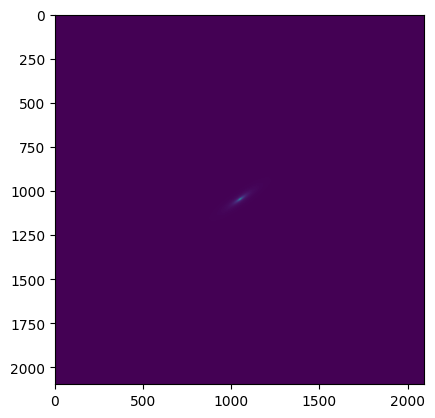

In [13]:
# Choose high Sersic index so a large image is required
gsparams = galsim.GSParams(maximum_fft_size=10000, folding_threshold=5e-3)
cosmos = galsim.COSMOSCatalog()
sersic = cosmos.makeGalaxy(1, gal_type='parametric', noise_pad_size=0, gsparams=gsparams)
shear_sersic = sersic.shear(g1=0.1, g2=0.1)

# Get nyquist scale and image size
scale = shear_sersic.nyquist_scale
nn = shear_sersic.getGoodImageSize(scale)
print(scale, nn)

# Draw the galaxy
start = time()
image = shear_sersic.shift(0.5*scale, 0.5*scale).drawImage(nx=nn, ny=nn, scale=scale, method='auto').array
print(time() - start)
plt.imshow(image)

0.7676975727081299


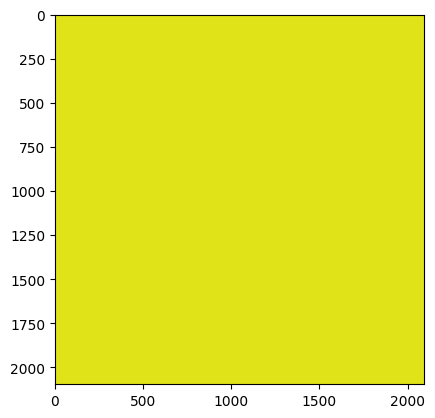

In [14]:
galstamp = batsim.Stamp(nn=nn, scale=scale)
Lens = batsim.LensTransform(gamma1=0.1, gamma2=0.1, kappa=0.0)
galstamp.set_transform(Lens)

start = time()
galfluxes = galstamp.sample_galaxy(sersic)
print(time()-start)

plt.imshow(image-galfluxes)

Galsim convolution and drawing time: 0.0022919178009033203


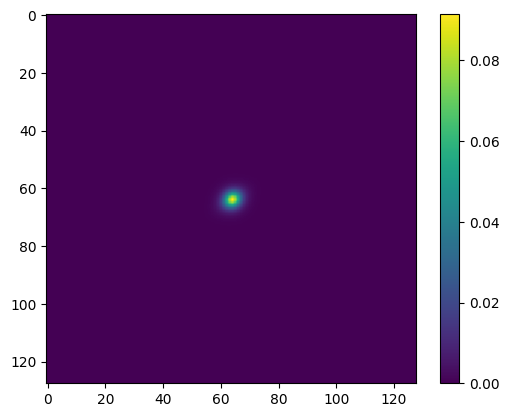

In [15]:
# create PSF obj
psf = galsim.Moffat(beta=3.5, fwhm=0.8, flux=1.0)

start = time()
galsim_conv = galsim.Convolve([shear_sersic, psf])

draw_scale = 0.2
draw_size = 128

gs_image = galsim_conv.shift(0.5*draw_scale, 0.5*draw_scale).drawImage(nx=draw_size, ny=draw_size, 
                                                             scale=draw_scale, method='auto').array
print('Galsim convolution and drawing time:', time()-start)

plt.imshow(gs_image)
plt.colorbar()

In [16]:
galsim_conv

galsim.Convolution([galsim.Transformation(galsim.Sersic(n=2.4000000000000004, scale_radius=0.0026777538701975474, trunc=0.0, flux=2.699868382752252, gsparams=galsim.GSParams(128,10000,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), jac=[[1.4991997878760952, -0.8436773384561815], [-0.6477683214395307, 1.0315552776052996]], offset=galsim.PositionD(x=0.0, y=0.0), flux_ratio=1.0, gsparams=galsim.GSParams(128,10000,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True), galsim.Moffat(beta=3.5, scale_radius=0.8547210416976097, trunc=0.0, flux=1.0, gsparams=galsim.GSParams(128,10000,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05))], real_space=False, gsparams=galsim.GSParams(128,10000,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)

### Implement Pythonic example of how BATSim could handle PSF convolution
- Once this is working move to C++ and figure out how best to structure within stamp class to make process intuitive

scipy backend time: 0.47283267974853516


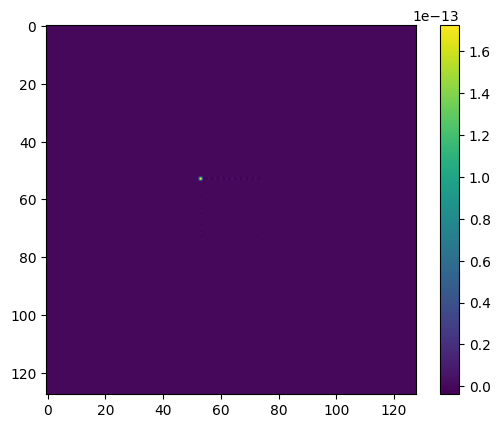

In [19]:
# Preparation steps for pyFFTW to improve performance
# This step is optional but recommended

galstamp = batsim.Stamp(nn=nn, scale=scale)
Lens = batsim.LensTransform(gamma1=0.1, gamma2=0.1, kappa=0.0)
galstamp.set_transform(Lens)
galprof = galstamp.sample_galaxy(sersic)
galprof /= np.sum(galprof) / sersic.flux  # Normalize galaxy

psf_nn = psf.getGoodImageSize(scale)
psfstamp = batsim.Stamp(nn=psf_nn, scale=scale)
psfprof = psfstamp.sample_galaxy(psf)
psfprof /= np.sum(psfprof) / psf.flux  # Normalize PSF

if psf_nn < nn:
    pad_width = ((nn - psf_nn) // 2,)
    psfprof = np.pad(psfprof, pad_width, mode='constant', constant_values=0)
elif psf_nn > nn:
    pad_width = ((psf_nn - nn) // 2,)
    galprof = np.pad(galprof, pad_width, mode='constant', constant_values=0)

start = time()
galKprof = fftshift(fft2(galprof))
psfKprof = fftshift(fft2(psfprof))

convKprof = galKprof * psfKprof

# crop the Fourier image to set pixel scale to drawing scale
pixel_factor =  draw_scale / scale
nn_cut = int(nn / pixel_factor)
maxN = nn//2 + nn_cut//2
minN = nn//2 - nn_cut//2
convKprof = convKprof[minN:maxN, minN:maxN]

# Inverse Fourier transform to obtain convolution result in real space
conv_im = ifftshift(ifft2(fftshift(convKprof)))
conv_im = conv_im.real # Throw away imaginary part
conv_size = np.shape(conv_im)[0]
print('scipy backend time:', time()-start)

# crop or pad the real space image to the desired size
if conv_size < draw_size:
    pad_width = ((draw_size - conv_size) // 2,)
    conv_im = np.pad(conv_im, pad_width, mode='constant', constant_values=0)
elif conv_size > draw_size:
    maxN = conv_size//2 + draw_size//2
    minN = conv_size//2 - draw_size//2
    conv_im = conv_im[minN:maxN, minN:maxN]

plt.imshow(conv_im)
plt.colorbar()

# Try using C profile to figure out where the slowdowns are

In [20]:
start = time()
stamp = batsim.Stamp(nn=128, scale=0.2)
Lens = batsim.LensTransform(gamma1=0.1, gamma2=0.1, kappa=0.0)
stamp.set_transform(Lens)
conv_im = stamp.sample_convolution(sersic, psf)
print('BATSim Convolution and drawing:', time()-start)

BATSim Convolution and drawing: 2.593904733657837


2.6998682 1.4366865582406445e-18


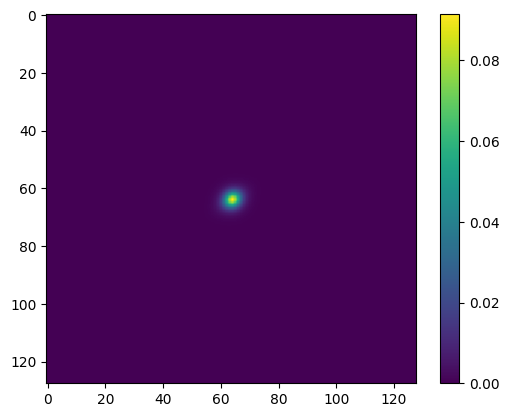

In [21]:
# Check fluxes are normalised correctly(ish)
print(np.sum(gs_image), np.sum(conv_im))
plt.imshow(gs_image-conv_im)
plt.colorbar()